In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import matplotlib as mpl
import numpy as np
import scipy as sp
import json
import sys

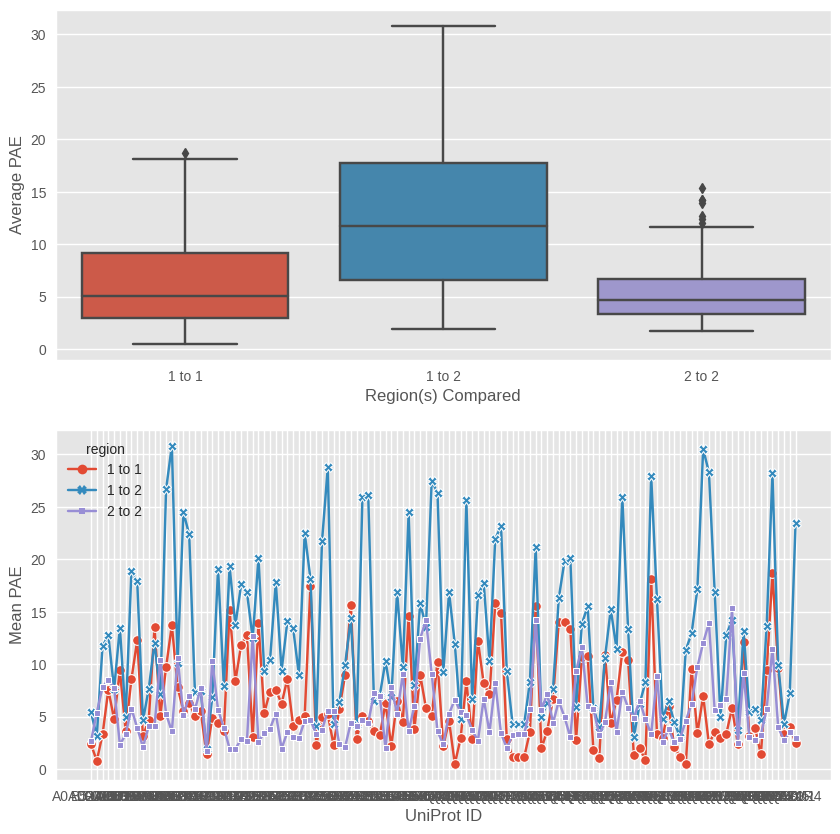

In [42]:
# This is for calculating percent that are within 2.5A of closed position. 
df_disorder = pd.read_csv('./project_pipeline/data/disorder.tsv', sep='\t').astype('object')
df_pae = df_disorder[['uniprot', 'mean_pae_1_1', 'mean_pae_1_2', 'mean_pae_2_2']]

plt.style.use('ggplot')
# Rename columns
df_pae = df_pae.rename(columns={'mean_pae_1_1': '1 to 1', 'mean_pae_1_2': '1 to 2', 'mean_pae_2_2': '2 to 2'})
df_pae = df_pae.drop_duplicates()
df_melt = df_pae.melt(id_vars=['uniprot'], var_name='region', value_name='mean_pae')

f, ax = plt.subplots(ncols=1, nrows=2, figsize=(10, 10))
sns.boxplot(data=df_melt, x='region', y='mean_pae', ax=ax[0])
ax[0].set_xlabel('Region(s) Compared')
ax[0].set_ylabel('Average PAE')


sns.lineplot(data=df_melt, x='uniprot', y='mean_pae', hue='region', style='region', markers=True, dashes=False, ax=ax[1])
ax[1].set_xlabel('UniProt ID')
ax[1].set_ylabel('Mean PAE')

plt.savefig('./project_pipeline/data/figures/mean_pae.png', dpi=300, bbox_inches='tight')

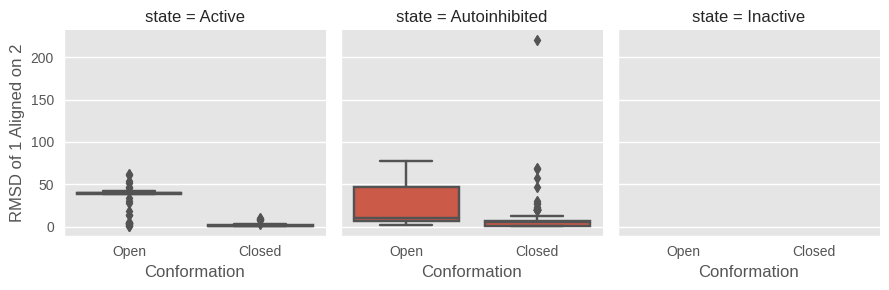

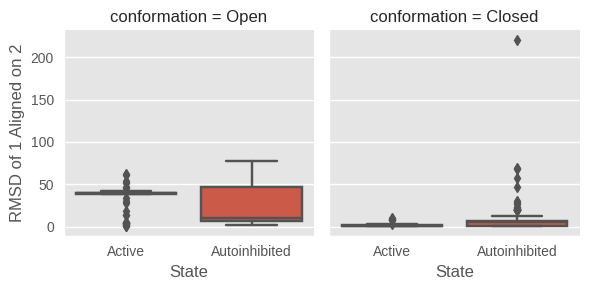

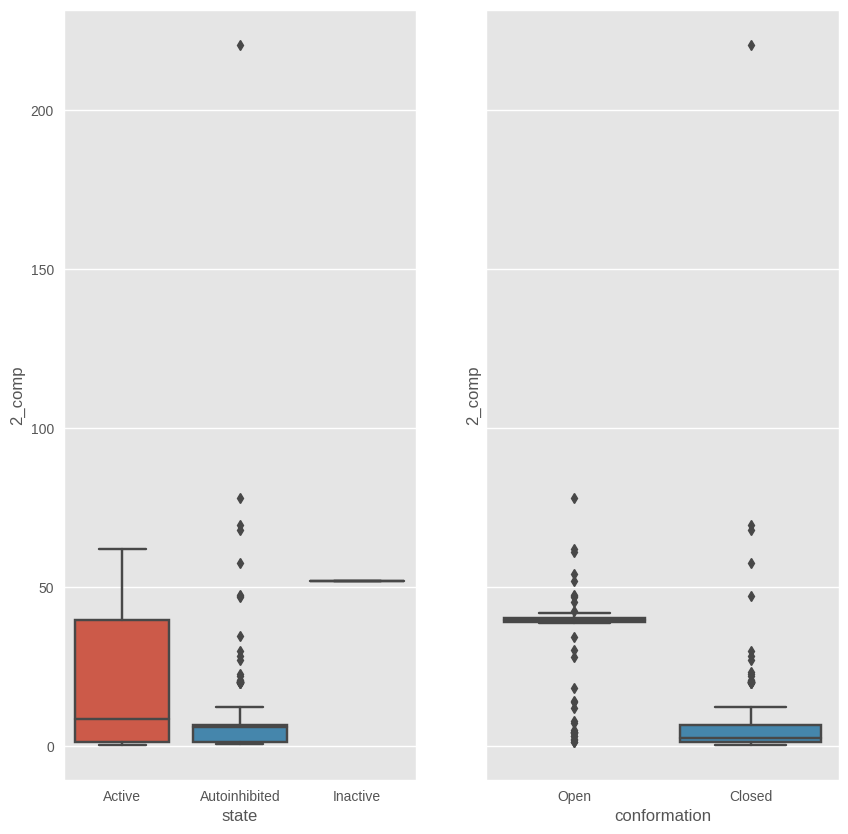

In [44]:
df_disorder = df_disorder.astype({'region_1_mean_plddt': 'float', '2_comp': 'float'})
df_active = df_disorder[df_disorder['state'] == 'Active']
df_autoin = df_disorder[df_disorder['state'] == 'Autoinhibited']
df_open = df_disorder[df_disorder['conformation'] == 'Open']
df_closed = df_disorder[df_disorder['conformation'] == 'Closed']

g1 = sns.FacetGrid(data=df_disorder, col='state')
g1.map(sns.boxplot, 'conformation', '2_comp', order=['Open', 'Closed'])
g1.set_axis_labels('Conformation', 'RMSD of 1 Aligned on 2')
g1.savefig('./project_pipeline/data/figures/rmsd_state.png', dpi=300, bbox_inches='tight')

g2 = sns.FacetGrid(data=df_disorder, col='conformation')
g2.map(sns.boxplot, 'state', '2_comp', order=['Active', 'Autoinhibited'])
g2.set_axis_labels('State', 'RMSD of 1 Aligned on 2')
g2.savefig('./project_pipeline/data/figures/rmsd_conformation.png', dpi=300, bbox_inches='tight')

fig, axes = plt.subplots(1, 2, figsize=(10, 10), sharey=True)

sns.boxplot(ax=axes[0], data=df_disorder, x='state', y='2_comp')
ax[0].set_ylabel('RMSD of 1 Aligned on 2')

sns.boxplot(ax=axes[1], data=df_disorder, x='conformation', y='2_comp')
ax[1].set_ylabel('RMSD of 1 Aligned on 2')

plt.savefig('./project_pipeline/data/figures/rmsd.png', dpi=300, bbox_inches='tight')